In [1]:
# HW#2 — Gabrielle Boyer-Baker, CSC380, Fall 2025
# Part 1 (fixed policies) + Part 2 (Value Iteration) on FrozenLake 8x8 (slippery)

import math
import statistics as stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gymnasium as gym

# Create 8x8 FrozenLake, slippery
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=True, render_mode="ansi")
env_unwrapped = env.unwrapped  # needed to access .P (transition dict)

# reset() returns (obs, info) in Gymnasium
obs, info = env.reset()

nS = int(env.observation_space.n)  # 64
nA = int(env.action_space.n)       # 4  (0=L,1=D,2=R,3=U)

print(f"states={nS}, actions={nA}")
print(env.render())  # grid


states=64, actions=4

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [2]:
def generate_random_policy(num_actions, num_states, seed=None):
    """
    Deterministic policy: for each state (0..num_states-1) pick a single action (0..num_actions-1).
    """
    rng = np.random.default_rng(seed)
    return rng.integers(low=0, high=num_actions, size=num_states)

def display_policy_grid(policy_1d):
    side = int(math.sqrt(len(policy_1d)))
    return policy_1d.reshape((side, side))

def run_one_experiment(env, policy, num_episodes, display=False):
    """
    Run num_episodes episodes following 'policy'. Return:
    goals, holes, total_rewards, total_goal_steps

    Gymnasium step signature: obs, reward, terminated, truncated, info
    We'll treat done = terminated or truncated.
    """
    goals = 0
    holes = 0
    total_rewards = 0
    total_goal_steps = 0

    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        rewards = 0.0
        steps = 0

        while not done:
            state = int(obs)                    # current discrete state index
            action = int(policy[state])         # pick action from deterministic policy
            obs, reward, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)
            steps += 1
            rewards += float(reward)

        total_rewards += rewards
        # In FrozenLake, reward==1.0 iff you reached the Goal; 0.0 otherwise (holes or falling elsewhere)
        if rewards == 1.0:
            goals += 1
            total_goal_steps += steps
        else:
            holes += 1

    return goals, holes, total_rewards, total_goal_steps


In [3]:
# Quick sanity check (small run)
test_policy = generate_random_policy(nA, nS, seed=123)
g, h, tr, tgs = run_one_experiment(env, test_policy, num_episodes=200)
print({"goals": g, "holes": h, "total_reward": tr, "mean_steps_to_goal": 0 if g==0 else tgs/g})


{'goals': 4, 'holes': 196, 'total_reward': 4.0, 'mean_steps_to_goal': 84.0}


In [4]:
# Assignment-scale run for Part 1
seeds = [17, 42, 73, 91, 123]        # any 5 distinct seeds are OK
num_experiments = 100
episodes_per_experiment = 10_000

results = []

for sd in seeds:
    policy = generate_random_policy(nA, nS, seed=sd)
    goals_list = []
    steps_to_goal_list = []

    for _ in range(num_experiments):
        goals, holes, total_rewards, total_goal_steps = run_one_experiment(
            env, policy, num_episodes=episodes_per_experiment
        )
        goals_list.append(goals)
        mean_steps = 0.0 if goals == 0 else (total_goal_steps / goals)
        steps_to_goal_list.append(mean_steps)

    results.append({
        "seed": sd,
        "policy": policy,
        "goals_list": goals_list,
        "mean_goals": float(np.mean(goals_list)),
        "stdev_goals": float(np.std(goals_list, ddof=1)),
        "mean_steps_to_goal": float(np.mean(steps_to_goal_list)),
    })

# Sort by mean_goals descending and take top 2
results_sorted = sorted(results, key=lambda d: d["mean_goals"], reverse=True)
top2 = results_sorted[:2]
top2


[{'seed': 123,
  'policy': array([0, 2, 2, 0, 3, 0, 1, 0, 1, 0, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 0, 2,
         1, 0, 0, 3, 3, 0, 1, 2, 0, 2, 1, 3, 2, 0, 3, 3, 0, 2, 3, 0, 0, 0,
         0, 1, 0, 2, 1, 0, 1, 0, 0, 1, 0, 2, 1, 3, 0, 2, 2, 3, 2, 3]),
  'goals_list': [92,
   85,
   94,
   87,
   88,
   88,
   91,
   91,
   83,
   99,
   91,
   79,
   71,
   80,
   97,
   84,
   95,
   80,
   73,
   90,
   113,
   95,
   80,
   96,
   78,
   80,
   93,
   88,
   97,
   90,
   101,
   79,
   89,
   88,
   82,
   95,
   78,
   84,
   90,
   87,
   91,
   83,
   97,
   86,
   79,
   88,
   109,
   68,
   79,
   81,
   84,
   116,
   82,
   104,
   86,
   92,
   78,
   93,
   90,
   94,
   80,
   84,
   86,
   73,
   80,
   83,
   88,
   83,
   85,
   75,
   92,
   88,
   84,
   83,
   92,
   81,
   73,
   93,
   89,
   79,
   91,
   90,
   84,
   89,
   92,
   98,
   90,
   79,
   93,
   96,
   87,
   93,
   88,
   96,
   81,
   86,
   87,
   101,
   105,
   91],
  'mean_goals': 87.89,
  'stdev_


=== TOP 1 POLICY (seed=123) ===
[[0 2 2 0 3 0 1 0]
 [1 0 1 3 1 3 1 1]
 [3 3 3 3 0 2 1 0]
 [0 3 3 0 1 2 0 2]
 [1 3 2 0 3 3 0 2]
 [3 0 0 0 0 1 0 2]
 [1 0 1 0 0 1 0 2]
 [1 3 0 2 2 3 2 3]]
mean_goals=87.9, stdev_goals=8.5, mean_steps_to_goal=61.91


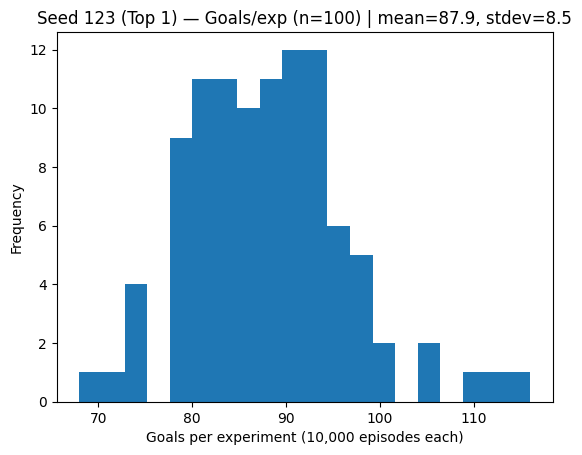


=== TOP 2 POLICY (seed=17) ===
[[2 3 0 0 1 2 3 1]
 [0 0 1 1 3 1 2 2]
 [0 2 0 0 2 1 1 2]
 [0 0 2 3 2 3 1 0]
 [2 2 2 2 1 0 2 0]
 [1 0 2 1 1 2 0 1]
 [2 3 0 3 1 1 3 0]
 [0 1 2 3 1 1 3 3]]
mean_goals=23.3, stdev_goals=5.0, mean_steps_to_goal=52.79


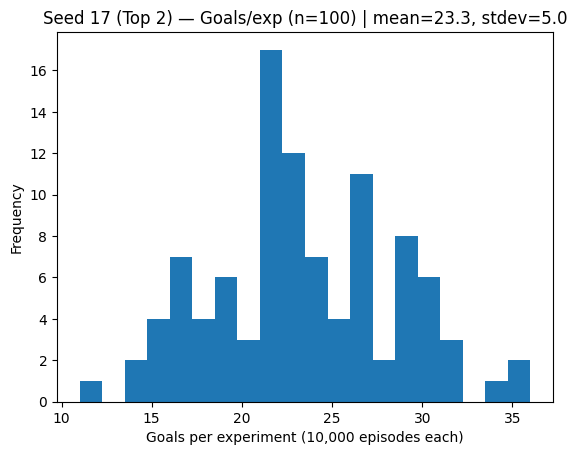

In [5]:
def plot_goals_hist(goals_list, title_prefix="Policy"):
    plt.figure()
    plt.hist(goals_list, bins=20)
    plt.title(f"{title_prefix} — Goals/exp (n={len(goals_list)}) "
              f"| mean={np.mean(goals_list):.1f}, stdev={np.std(goals_list, ddof=1):.1f}")
    plt.xlabel("Goals per experiment (10,000 episodes each)")
    plt.ylabel("Frequency")
    plt.show()

for rank, entry in enumerate(top2, start=1):
    grid = display_policy_grid(entry["policy"])
    print(f"\n=== TOP {rank} POLICY (seed={entry['seed']}) ===")
    print(grid)
    print(f"mean_goals={entry['mean_goals']:.1f}, stdev_goals={entry['stdev_goals']:.1f}, "
          f"mean_steps_to_goal={entry['mean_steps_to_goal']:.2f}")
    plot_goals_hist(entry["goals_list"], title_prefix=f"Seed {entry['seed']} (Top {rank})")


In [6]:
# === Part 2: Value Iteration per spec ===
# gamma=1.0, theta=1e-4, initialize V(s) with small non-zero for non-terminals and 0.0 for terminals
# use TWO tables each sweep (write into V_new; copy back to V)
# compute optimal policy greedily from converged V using env_unwrapped.P

gamma = 1.0
theta = 1e-4

# Detect terminal states from env.P: terminals have transitions that immediately end episodes
terminal_states = set()
P = env_unwrapped.P  # dict: P[s][a] = list of (prob, next_state, reward, done)
for s in range(nS):
    # In FrozenLake, terminals (holes + goal) effectively have no continuing transitions
    # We'll mark s terminal if for every action, all transitions mark done=True.
    is_terminal = True
    for a in range(nA):
        if any(not t[3] for t in P[s][a]):  # t = (prob, ns, reward, done)
            is_terminal = False
            break
    if is_terminal:
        terminal_states.add(s)

# Initialize V: small random for non-terminals, zero for terminals
rng = np.random.default_rng(2025)
V_init = np.zeros(nS, dtype=float)
for s in range(nS):
    if s not in terminal_states:
        V_init[s] = rng.uniform(1e-5, 1e-3)  # (0, 0.001]
    else:
        V_init[s] = 0.0

def value_iteration(P, nS, nA, gamma=1.0, theta=1e-4, V0=None):
    V = np.array(V0, dtype=float) if V0 is not None else np.zeros(nS, dtype=float)
    while True:
        delta = 0.0
        V_new = np.copy(V)  # write table
        for s in range(nS):
            # Bellman optimality backup: max_a sum_{s'} p*(r + gamma*V[s'])
            action_values = []
            for a in range(nA):
                q = 0.0
                for (prob, ns, reward, done) in P[s][a]:
                    continuation = 0.0 if done else V[ns]
                    q += prob * (reward + gamma * continuation)
                action_values.append(q)
            V_new[s] = max(action_values)
            delta = max(delta, abs(V_new[s] - V[s]))
        V = V_new
        if delta < theta:
            break

    # Greedy policy from V
    policy = np.zeros(nS, dtype=int)
    for s in range(nS):
        action_values = []
        for a in range(nA):
            q = 0.0
            for (prob, ns, reward, done) in P[s][a]:
                continuation = 0.0 if done else V[ns]
                q += prob * (reward + gamma * continuation)
            action_values.append(q)
        policy[s] = int(np.argmax(action_values))
    return V, policy

V_star, pi_star = value_iteration(P, nS, nA, gamma=gamma, theta=theta, V0=V_init)

print("\n=== Optimal Policy (8x8) ===")
print(display_policy_grid(pi_star))

print("\n=== Converged V(s) (8x8) ===")
print(display_policy_grid(V_star))



=== Optimal Policy (8x8) ===
[[3 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 2]
 [0 0 0 0 2 3 3 2]
 [0 0 0 1 0 0 2 2]
 [0 3 0 0 2 1 3 2]
 [0 0 0 1 3 0 0 2]
 [0 0 2 0 0 0 0 2]
 [0 1 0 0 1 2 1 0]]

=== Converged V(s) (8x8) ===
[[0.99823408 0.99831125 0.99842273 0.99854424 0.99866676 0.99878392
  0.99888867 0.99896533]
 [0.99821482 0.99827359 0.99837014 0.99848535 0.99860786 0.99873232
  0.99886058 0.99901055]
 [0.99683346 0.9752579  0.92389333 0.         0.85532048 0.94498838
  0.9809665  0.99909901]
 [0.9955858  0.9307912  0.79815969 0.47350742 0.62242145 0.
  0.94378576 0.99922686]
 [0.99452194 0.8216892  0.53991742 0.         0.53848773 0.61046692
  0.85120282 0.99938849]
 [0.99368449 0.         0.         0.16763097 0.38261139 0.44174126
  0.         0.99957684]
 [0.99310691 0.         0.19328997 0.12029868 0.         0.33216808
  0.         0.9997837 ]
 [0.99281225 0.7261085  0.45962788 0.         0.27738472 0.55477295
  0.77738472 0.        ]]



Optimal policy over 100 experiments (each 10000 episodes):
Goals: mean=5152.8, stdev=53.5
Mean steps-to-goal: 67.11


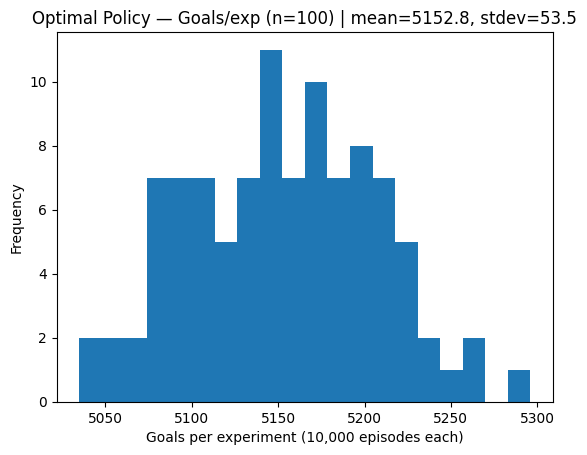

In [7]:
# Evaluate the optimal policy with the same experiment structure
num_experiments_opt = 100
episodes_per_experiment_opt = 10_000

opt_goals = []
opt_steps_to_goal = []

for _ in range(num_experiments_opt):
    g, h, tr, tgs = run_one_experiment(env, pi_star, episodes_per_experiment_opt)
    opt_goals.append(g)
    opt_steps_to_goal.append(0.0 if g == 0 else (tgs / g))

print(f"\nOptimal policy over {num_experiments_opt} experiments "
      f"(each {episodes_per_experiment_opt} episodes):")
print(f"Goals: mean={np.mean(opt_goals):.1f}, stdev={np.std(opt_goals, ddof=1):.1f}")
print(f"Mean steps-to-goal: {np.mean(opt_steps_to_goal):.2f}")

plt.figure()
plt.hist(opt_goals, bins=20)
plt.title(f"Optimal Policy — Goals/exp (n={num_experiments_opt}) "
          f"| mean={np.mean(opt_goals):.1f}, stdev={np.std(opt_goals, ddof=1):.1f}")
plt.xlabel("Goals per experiment (10,000 episodes each)")
plt.ylabel("Frequency")
plt.show()


In [8]:
# === Save figures and text assets for the write-up ===
import os, numpy as np, matplotlib.pyplot as plt

outdir = "deliverables"
os.makedirs(outdir, exist_ok=True)

# Save Top-2 policy grids as .npy and .txt
for rank, entry in enumerate(top2, start=1):
    grid = display_policy_grid(entry["policy"])
    np.savetxt(f"{outdir}/part1_top{rank}_policy_grid.txt", grid, fmt="%d")
    with open(f"{outdir}/part1_top{rank}_stats.txt", "w") as f:
        f.write(
            f"seed={entry['seed']}\n"
            f"mean_goals={entry['mean_goals']:.3f}\n"
            f"stdev_goals={entry['stdev_goals']:.3f}\n"
            f"mean_steps_to_goal={entry['mean_steps_to_goal']:.3f}\n"
        )

# Replot and save histograms for Top-2
def save_hist(goals_list, path, title):
    plt.figure()
    plt.hist(goals_list, bins=20)
    plt.title(title)
    plt.xlabel("Goals per experiment (10,000 episodes each)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(path, dpi=180)
    plt.close()

for rank, entry in enumerate(top2, start=1):
    title = (f"Seed {entry['seed']} (Top {rank}) — Goals/exp (n={len(entry['goals_list'])}) | "
             f"mean={np.mean(entry['goals_list']):.1f}, stdev={np.std(entry['goals_list'], ddof=1):.1f}")
    save_hist(entry["goals_list"], f"{outdir}/part1_top{rank}_hist.png", title)

# Save Part 2 assets
np.savetxt(f"{outdir}/part2_opt_policy_grid.txt", display_policy_grid(pi_star), fmt="%d")
np.savetxt(f"{outdir}/part2_V_table.txt", display_policy_grid(V_star), fmt="%.6f")

# Recompute / replot the optimal-policy histogram and save
from math import isnan
plt.figure()
plt.hist(opt_goals, bins=20)
plt.title(f"Optimal Policy — Goals/exp (n={len(opt_goals)}) | "
          f"mean={np.mean(opt_goals):.1f}, stdev={np.std(opt_goals, ddof=1):.1f}")
plt.xlabel("Goals per experiment (10,000 episodes each)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(f"{outdir}/part2_opt_hist.png", dpi=180)
plt.close()

print("Saved to ./deliverables/")


Saved to ./deliverables/
